In [5]:
!pip install cirq

Circuito de Grover con ancilla y Toffoli:
0: ─────────H───────@───H───X───────@───X───H───────M('result')───
                    │               │               │
1: ─────────H───────@───H───X───H───X───H───X───H───M─────────────
                    │
Ancilla: ───X───H───X─────────────────────────────────────────────


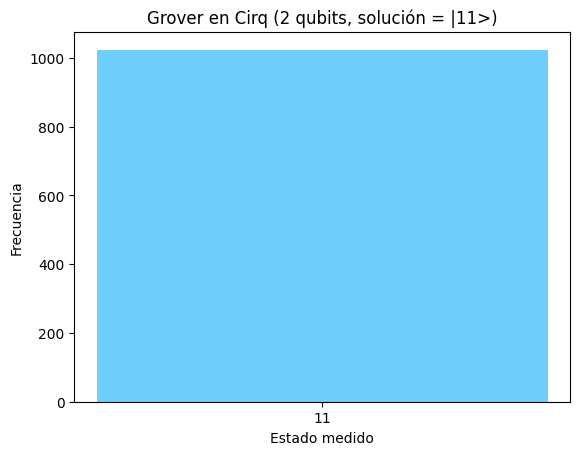

Resultados de la medición: {'11': 1024}


In [6]:
import cirq
import matplotlib.pyplot as plt

# Definir qubits: 2 qubits de entrada + 1 ancilla
q0, q1 = cirq.LineQubit.range(2)
ancilla = cirq.NamedQubit("Ancilla")

# Función para crear el oracle para |11⟩ usando Toffoli
def make_oracle(qubits, ancilla):
    # Para |11>, simplemente Toffoli entre q0,q1 -> ancilla
    return cirq.TOFFOLI(qubits[0], qubits[1], ancilla)

# Función para una iteración de Grover
def grover_iteration(qubits, ancilla, oracle):
    circuit = cirq.Circuit()

    # 1. Superposición inicial
    circuit.append(cirq.H.on_each(*qubits))

    # 2. Preparar ancilla en |->
    circuit.append([cirq.X(ancilla), cirq.H(ancilla)])

    # 3. Aplicar oracle
    circuit.append(oracle)

    # 4. Difusor (inversión sobre la media)
    circuit.append(cirq.H.on_each(*qubits))
    circuit.append(cirq.X.on_each(*qubits))
    circuit.append(cirq.H(qubits[1]))
    circuit.append(cirq.CNOT(qubits[0], qubits[1]))
    circuit.append(cirq.H(qubits[1]))
    circuit.append(cirq.X.on_each(*qubits))
    circuit.append(cirq.H.on_each(*qubits))

    # 5. Medición
    circuit.append(cirq.measure(*qubits, key='result'))

    return circuit

# Crear el oracle
oracle = make_oracle([q0, q1], ancilla)

# Construir el circuito de Grover
circuit = grover_iteration([q0, q1], ancilla, oracle)

print("Circuito de Grover con ancilla y Toffoli:")
print(circuit)

# Simulación
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=1024)

# Contar resultados
counts = result.histogram(key='result')
labels = [f"{b:02b}" for b in counts.keys()]

# Dibujar histograma
plt.bar(labels, counts.values(), color="#70CEFF")
plt.xlabel("Estado medido")
plt.ylabel("Frecuencia")
plt.title("Grover en Cirq (2 qubits, solución = |11>)")
plt.show()

# Mostrar resultados
print("Resultados de la medición:", dict(zip(labels, counts.values())))


Circuito de Grover con ancilla y Toffoli:
(0, 6): ───H───────@───H───X───────@───X───H───────M('result')───
                   │               │               │
(0, 7): ───H───────@───H───X───H───X───H───X───H───M─────────────
                   │
(0, 8): ───X───H───X─────────────────────────────────────────────


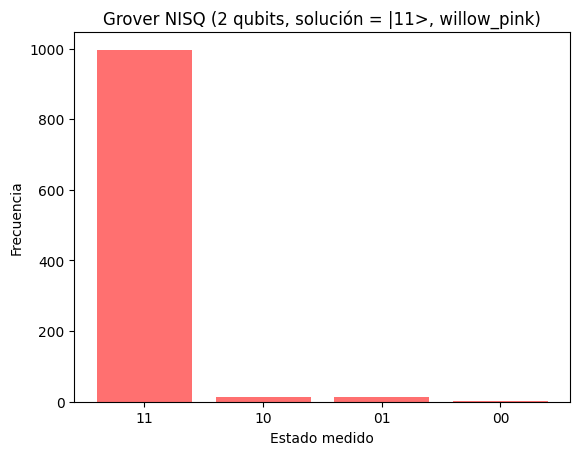

Resultados de la medición con ruido realista: {'11': 997, '10': 12, '01': 13, '00': 2}


In [7]:
import cirq
import cirq_google
import matplotlib.pyplot as plt

# --- Qubits: usar los qubits del procesador virtual ---
# Tomamos los primeros 3 qubits que figuran en noise_props
processor_id = "willow_pink"
noise_props = cirq_google.engine.load_device_noise_properties(processor_id)
qubits_list = list(noise_props.qubits)[:3]  # necesitamos 2 input + 1 ancilla
q0, q1, ancilla = qubits_list

# --- Oracle para |11> usando Toffoli ---
def make_oracle(qubits, ancilla):
    return cirq.TOFFOLI(qubits[0], qubits[1], ancilla)

# --- Iteración de Grover ---
def grover_iteration(qubits, ancilla, oracle):
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(*qubits))
    circuit.append([cirq.X(ancilla), cirq.H(ancilla)])
    circuit.append(oracle)
    circuit.append(cirq.H.on_each(*qubits))
    circuit.append(cirq.X.on_each(*qubits))
    circuit.append(cirq.H(qubits[1]))
    circuit.append(cirq.CNOT(qubits[0], qubits[1]))
    circuit.append(cirq.H(qubits[1]))
    circuit.append(cirq.X.on_each(*qubits))
    circuit.append(cirq.H.on_each(*qubits))
    circuit.append(cirq.measure(*qubits, key='result'))
    return circuit

# --- Construir circuito ---
oracle = make_oracle([q0, q1], ancilla)
circuit = grover_iteration([q0, q1], ancilla, oracle)

print("Circuito de Grover con ancilla y Toffoli:")
print(circuit)

# --- Crear NoiseModel desde las propiedades del procesador ---
noise_model = cirq_google.NoiseModelFromGoogleNoiseProperties(noise_props)

# --- Simulación con ruido realista ---
simulator = cirq.DensityMatrixSimulator(noise=noise_model)
result = simulator.run(circuit, repetitions=1024)

# --- Contar resultados ---
counts = result.histogram(key='result')
labels = [f"{b:02b}" for b in counts.keys()]

# --- Dibujar histograma ---
plt.bar(labels, counts.values(), color="#FF7070")
plt.xlabel("Estado medido")
plt.ylabel("Frecuencia")
plt.title(f"Grover NISQ (2 qubits, solución = |11>, {processor_id})")
plt.show()

# --- Resultados ---
print("Resultados de la medición con ruido realista:", dict(zip(labels, counts.values())))
